### References: http://www.scholarpedia.org/article/Echo_state_network, Hoerzer et al. 2014 Cerebral Cortex; Kumar et al. 2022 Cerebral Cortex

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# task setup
total_instruments = 5
trial_length = 100 # ms, change according to how long each trial was
dt = 1 # ms , time interval/step to run differential equation. keep this according to sampling frequency. if samp freq is 1000Hz, dt = 1, 
total_trials = 10
test_trials = [1,5,10]  # trials in which classifier is not updated

# pseudo eeg setup
brain_size = 1000
num_eeg_channels = 78

In [3]:
# define dataset
def generate_audio_data(instrument,total_instruments, trial_length=100,dt=1, seed=0):
    # length is in seconds
    # timestep is in ms
    T = trial_length//dt
    np.random.seed(seed)
    I = np.random.normal(size=(T, total_instruments))
    I[:,instrument] += np.random.normal(loc=3, scale=0.5,size=(T))
    return I

class Pseudo_Brain_EEG:
    def __init__(self,audio_size,brain_size=1000, eeg_channels=78):
        self.brain_size = brain_size
        self.eeg_channels = eeg_channels
        self.brain_matrix = np.random.normal(size=(brain_size,audio_size)) * 1/np.sqrt(brain_size)
        self.eeg_matrix = np.random.normal(size=(eeg_channels, brain_size)) * 1/np.sqrt(eeg_channels)

    def get_eeg_activity(self, audio_x):
        # get brain activity 
        self.brain = np.dot(self.brain_matrix, audio_x) # scale between 0 to max
        # get eeg activity
        self.eeg = np.dot(self.eeg_matrix, self.brain) # scale between -1,1
        return self.eeg
    
eeg_func = Pseudo_Brain_EEG(audio_size=total_instruments, eeg_channels=num_eeg_channels, brain_size=brain_size)

In [4]:
class ReservoirComputingNetwork:
    def __init__(self, input_size, reservoir_size, output_size, chaos=1.2, tau=10, dt=1, learning_rate=0.001):
        self.tau = tau  # time constant
        self.alpha = dt/self.tau
        self.nin = input_size
        self.nrnn = reservoir_size
        self.nout = output_size
        self.cp = [1,0.1]  #connection probability
        self.lr = learning_rate
        self.w_in_scale = 0.1
        
        # Initialize weights
        winconn = np.random.uniform(-1, 1, (self.nrnn, self.nin)) * self.w_in_scale  # uniform dist [-1,1]
        winprob = np.random.choice([0, 1], (self.nrnn, self.nin), p=[1 - self.cp[0], self.cp[0]])
        self.w_in = np.multiply(winconn, winprob) # cater to different input connection probabilities

        connex = np.random.normal(0, np.sqrt(1 / (self.cp[1] * self.nrnn)), size=(self.nrnn, self.nrnn))
        prob = np.random.choice([0, 1], (self.nrnn, self.nrnn), p=[1 - self.cp[1], self.cp[1]])
        w_rec = chaos * np.multiply(connex, prob)  # initialise random network with connection probability
        w_rec *= (np.eye(self.nrnn) == 0)  # remove self recurrence
        self.w_rec = w_rec

        self.w_fb = np.random.uniform(-1, 1, (self.nrnn, self.nout)) 
        
        self.w_out = np.random.rand(output_size, reservoir_size) * 1/reservoir_size

    def reset(self,trial):
        np.random.seed(trial)
        self.state = np.random.rand(self.nrnn)*0.1
        self.output = np.random.rand(self.nout)*0.1

    
    def run(self, input_vector):
        # Update reservoir state using leaky integrator rule
        I = np.dot(self.w_in, input_vector)
        h = np.dot(self.w_rec, self.state)
        fb = np.dot(self.w_fb, self.output)
        self.state = (1.0 - self.alpha) * self.state + self.alpha * np.tanh(I + h + fb)
        
        # Compute output
        self.output = np.dot(self.w_out, self.state)
        return self.output
    
    def learn(self, predicted_output,target_output):
        # Simple delta rule (Gradient descent on the output weights)
        # Run network to get current output
        self.error = target_output - predicted_output
        
        # Update the output weights using the delta rule
        self.w_out += self.lr * np.outer(self.error, self.state)
        return self.error

In [5]:
ninputs = num_eeg_channels
nrnn = 1024
noutputs = total_instruments
tau = 20
chaos = 1.5
lr = 0.001
reservoir = ReservoirComputingNetwork(input_size=ninputs, reservoir_size=nrnn, output_size=noutputs,chaos=chaos, tau=tau,learning_rate=lr)
init_wout = reservoir.w_out.copy()

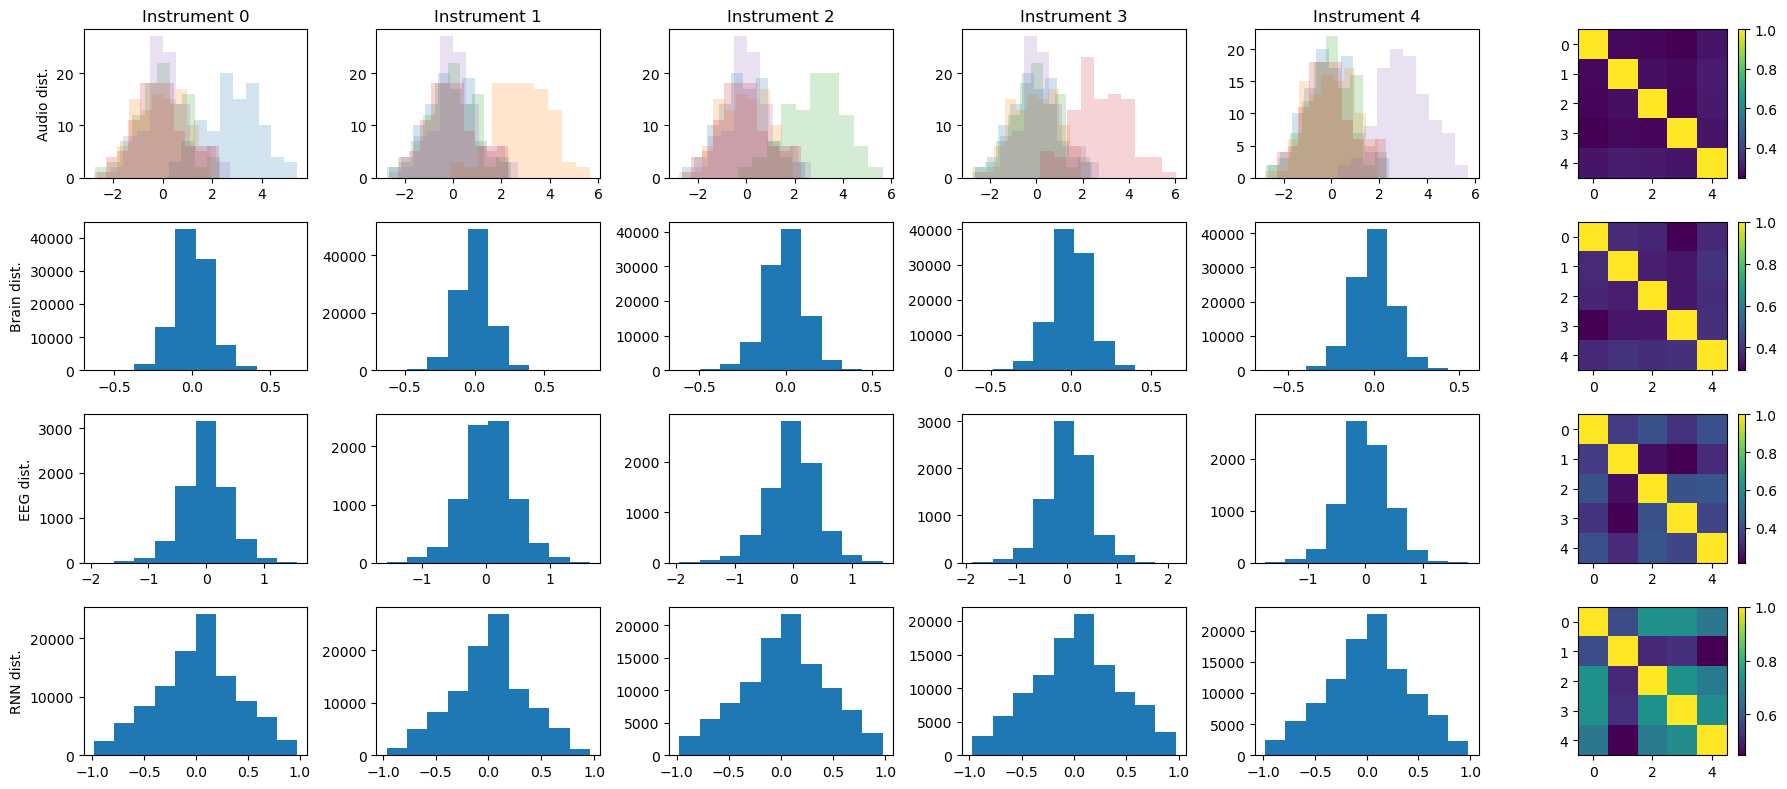

In [6]:
# plot difference in data distribution
# ensure that different instruments elicit anti-correlated audio data, brain signals, EEG data
res = np.zeros([total_instruments, trial_length, nrnn])
audios = np.zeros([total_instruments, trial_length, total_instruments])
brains = np.zeros([total_instruments, trial_length, brain_size])
eegs = np.zeros([total_instruments, trial_length, num_eeg_channels])

f,ax = plt.subplots(4,6,figsize=(3*6,2*4))
for instrument in range(total_instruments):
    audios[instrument] = generate_audio_data(instrument, total_instruments, trial_length)
    
    for d in range(total_instruments):
        ax[0,instrument].hist(audios[instrument][:,d],alpha=0.2)

    eeg_func.get_eeg_activity(audios[instrument].T)
    
    brains[instrument] = eeg_func.brain.T
    eegs[instrument] = eeg_func.eeg.T

    ax[1,instrument].hist(brains[instrument].reshape(-1))
    ax[2,instrument].hist(eegs[instrument].reshape(-1))


    reservoir.reset(0)
    for t in range(trial_length):
        pred = reservoir.run(eeg_func.eeg[:,0])
        res[instrument, t] = reservoir.state

    ax[3,instrument].hist(np.array(res[instrument]).reshape(-1))

    ax[0,instrument].set_title(f'Instrument {instrument}')

corrs = np.zeros([total_instruments, total_instruments, 4])
for d, data in enumerate([audios, brains, eegs, res]):
    for i in range(total_instruments):
        for j in range(total_instruments):
            corrs[i,j,d] = np.corrcoef(data[i].reshape(-1), data[j].reshape(-1))[0,1]
    im = ax[d,5].imshow(corrs[:,:,d])
    plt.colorbar(im,ax=ax[d,5])

ax[0,0].set_ylabel('Audio dist.')
ax[1,0].set_ylabel('Brain dist.')
ax[2,0].set_ylabel('EEG dist.')
ax[3,0].set_ylabel('RNN dist.')

f.tight_layout()

In [7]:
record_output = np.zeros([total_trials, total_instruments, trial_length, noutputs])
record_error = np.zeros([total_trials, total_instruments, trial_length, noutputs])

record_ground = np.zeros([total_trials, total_instruments, noutputs])

for trial in range(total_trials):
    instrument_cls = np.random.choice(np.arange(total_instruments),total_instruments, replace=False)

    for i, instrument in enumerate(instrument_cls):

        audio_data = generate_audio_data(instrument, total_instruments)
        ground_truth = np.zeros(total_instruments)
        ground_truth[instrument] = 1
        record_ground[trial, i] = ground_truth
        reservoir.reset(trial)
        
        print(f'Trial {trial}, Instrument {instrument}')
        for time in range(trial_length):
            x = audio_data[time]

            # get eeg data
            x_eeg = eeg_func.get_eeg_activity(x)

            # predict classifier output
            pred = reservoir.run(x_eeg)

            # online learning to classify , if trial is in test_trials, do not change classifier weights/learn
            if trial+1 not in test_trials:
                error = reservoir.learn(pred, ground_truth)

            record_output[trial, instrument, time] = pred
            record_error[trial, instrument, time] = ground_truth - pred

Trial 0, Instrument 2
Trial 0, Instrument 4
Trial 0, Instrument 3
Trial 0, Instrument 0
Trial 0, Instrument 1
Trial 1, Instrument 2
Trial 1, Instrument 4
Trial 1, Instrument 3
Trial 1, Instrument 0
Trial 1, Instrument 1
Trial 2, Instrument 0
Trial 2, Instrument 2
Trial 2, Instrument 1
Trial 2, Instrument 4
Trial 2, Instrument 3
Trial 3, Instrument 0
Trial 3, Instrument 2
Trial 3, Instrument 1
Trial 3, Instrument 4
Trial 3, Instrument 3
Trial 4, Instrument 4
Trial 4, Instrument 2
Trial 4, Instrument 0
Trial 4, Instrument 3
Trial 4, Instrument 1
Trial 5, Instrument 1
Trial 5, Instrument 0
Trial 5, Instrument 4
Trial 5, Instrument 2
Trial 5, Instrument 3
Trial 6, Instrument 0
Trial 6, Instrument 2
Trial 6, Instrument 1
Trial 6, Instrument 4
Trial 6, Instrument 3
Trial 7, Instrument 0
Trial 7, Instrument 4
Trial 7, Instrument 2
Trial 7, Instrument 3
Trial 7, Instrument 1
Trial 8, Instrument 1
Trial 8, Instrument 2
Trial 8, Instrument 3
Trial 8, Instrument 4
Trial 8, Instrument 0
Trial 9, I

In [8]:
np.argmax(record_output[0],axis=2).shape

(5, 100)

In [9]:
0 == np.argmax(record_output[:,i],axis=2)

array([[False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, Fals

Test classication error Before Training: 0.172, Change is 0.2
Test classication error After Training: 0.998


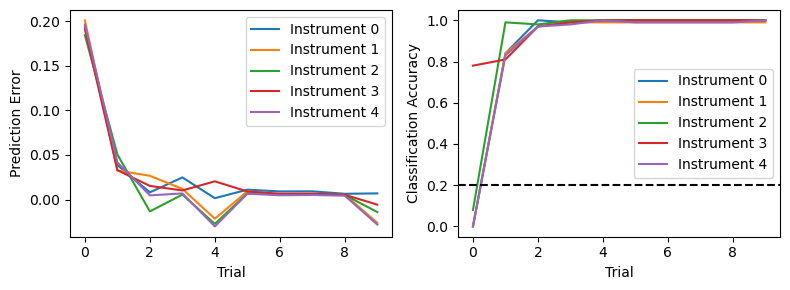

In [10]:
f,ax = plt.subplots(1,2,figsize=(8,3))
for i in range(total_instruments):
    ax[0].plot(np.mean(np.mean(record_error[:,i],axis=1),axis=1), label=f'Instrument {i}')
ax[0].legend()
ax[0].set_xlabel('Trial')
ax[0].set_ylabel('Prediction Error')

for i in range(total_instruments):
    ax[1].plot(np.mean(i == np.argmax(record_output[:,i],axis=2),axis=1), label=f'Instrument {i}')
ax[1].legend()
ax[1].set_xlabel('Trial')
ax[1].set_ylabel('Classification Accuracy')
ax[1].axhline(1/total_instruments,color='k',linestyle='--')

f.tight_layout()

before_test = np.mean(np.arange(5)[:,None] == np.argmax(record_output[0, :,:],axis=2))
after_test = np.mean(np.arange(5)[:,None] == np.argmax(record_output[-1, :,:],axis=2))
print(f'Test classication error Before Training: {before_test}, Change is {1/total_instruments}')
print(f'Test classication error After Training: {after_test}')


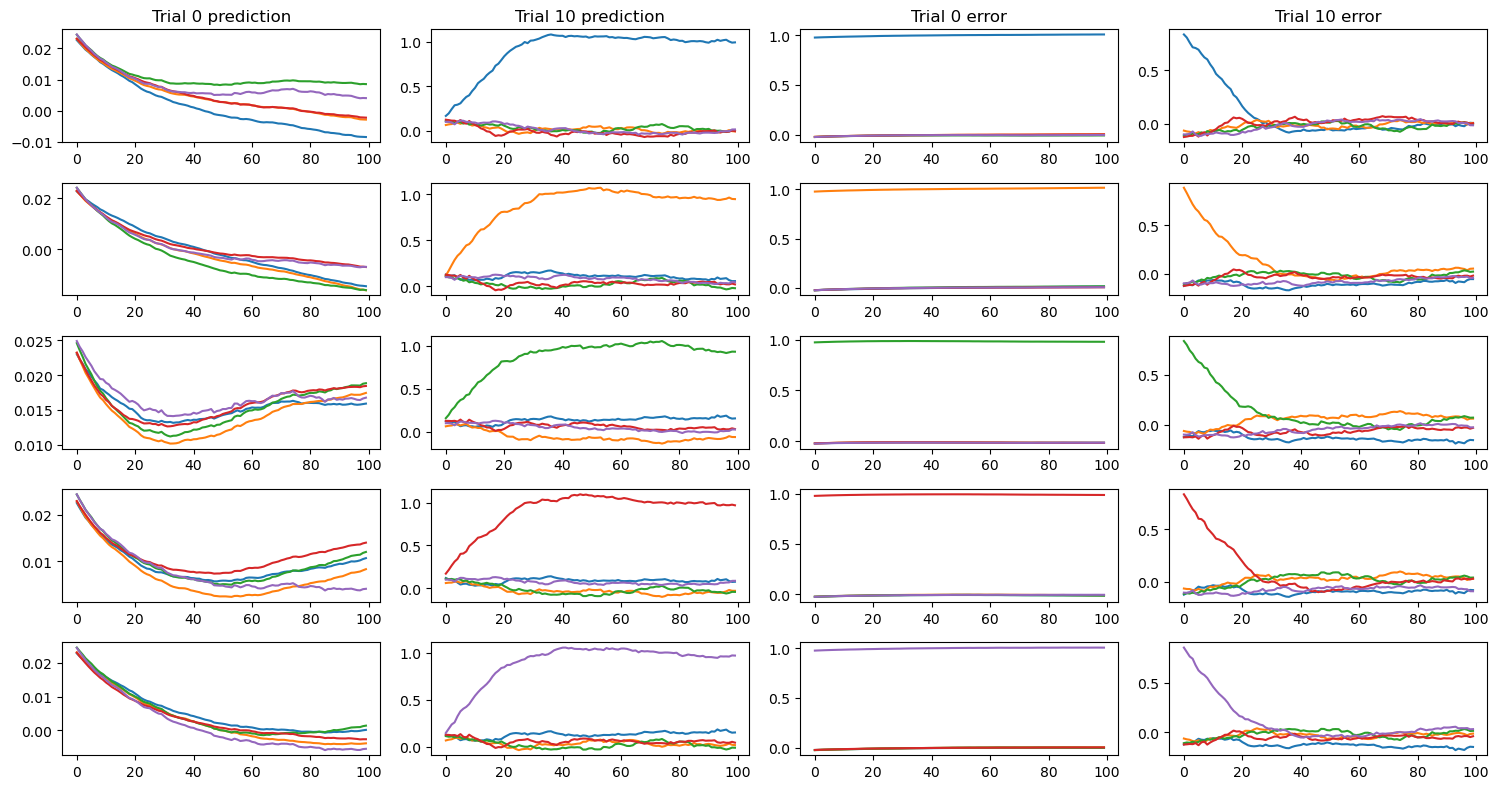

In [11]:
instrument = 2

f,ax = plt.subplots(total_instruments,4,figsize=(3*total_instruments,2*4))

for instrument in range(total_instruments):
    ax[instrument, 0].plot(record_output[0,instrument])

    ax[instrument, 1].plot(record_output[-1,instrument])

    ax[instrument, 2].plot(record_error[0,instrument])

    ax[instrument, 3].plot(record_error[-1,instrument])

ax[0,0].set_title('Trial 0 prediction')
ax[0,1].set_title(f'Trial {total_trials} prediction')

ax[0,2].set_title('Trial 0 error')
ax[0,3].set_title(f'Trial {total_trials} error')

f.tight_layout()

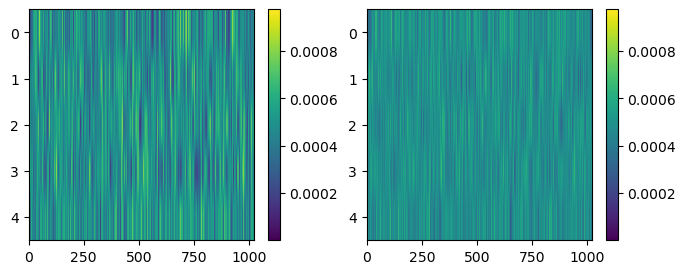

In [12]:
f,ax = plt.subplots(1,2,figsize=(4*2,3))

im = ax[0].imshow(init_wout,aspect='auto')
plt.colorbar(im,ax=ax[0])
im2 = ax[1].imshow(reservoir.w_out,aspect='auto')
plt.colorbar(im,ax=ax[1])